___________
# Modeling Adelinia Grande Bloom Status
____________

# Guide <a id='top'></a>

## 1. Import necessary libraries

## 2. Import and select phenology data [Link](#import)
 - 2a. import data
 - 2b. drop dead and ambiguous observations
 - 2c. select species and reorder data

## 3. Visualize climate features: training data [Link](#visualize)
 - 3a. [climate variable descriptions](#feature_definitions)
 - 3b. correlation plot of all climate features in Adelinia grande dataframe
 - 3c. boxplots of climate features

## 4. Feature and model selection with Pycaret [Link](#select)
 - 4a. drop fixed-period features not evenly measured from current date: 'MonSumPrec', 'WkSumPrec'
 - 4b. split data into training (%80) and testing (20%) sets
 - 4c. run Pycaret feature/model selection
 
## 5. Train the model: Adelinia grande, Pacific Hound's Tongue [Link](#train)
 - 5a. [Random Forest](#train_rf)
 - 5b. [K Nearest Neighbors](#train_knn)
 - 5c. [Extra Trees](#train_et)
 - 5d. [Gradient Boosting](#train_gb)
 - 5e. [table of training model comparisons](#train_model_comp)
 
## 6. Test the model: unseen data from Mt. Diablo [Link](#test)
 - 6a. import unseen data
 - 6b. select and filter test data

## 7. Visualize climate features: test data [Link](#test_visualize)
 - 7a. correlation plot of all climate features in Adelinia grande dataframe
 - 7b. boxplots of climate features

## 8. Model test data [Link](#model)
 - 8a. [Random Forest](#test_rf)
 - 8b. [K Nearest Neighbors](#test_knn)
 - 8c. [Extra Trees](#test_et)
 - 8d. [Gradient Boosting](#test_gb)
 - 8e. [table of training model comparisons](#test_model_comp)
 
## 9. Summary

_____________________
# 1. Import necessary libraries

In [54]:
#!pip install mlflow

import requests
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier,
                             AdaBoostClassifier, VotingClassifier)
from sklearn import preprocessing
from sklearn.metrics import (f1_score, accuracy_score,confusion_matrix,
                            plot_confusion_matrix, ConfusionMatrixDisplay)
from sklearn.feature_selection import RFE

import pycaret
from pycaret.classification import (setup, compare_models, tune_model)


<a id='top'></a>
# 2. Import and select phenology data

<br>Observations of seven species of wildflowers were labeled as :
<br>0 = pre bloom
<br>1 = in bloom
<br>2 = in bud
<br>3 = fruiting
<br>5 = long dead and dried
<br>
<br>Modeling was done on Adelinia grande, Pacific Hound's Tongue

### 2a. import data

In [2]:
# import from GitHub:Floydworks
url = ('https://raw.githubusercontent.com/Floydworks/WildflowerFinder_Phenology_Tool/main/cleaned_data_files/df_phenology_status_2017_2022.csv')
download = requests.get(url).content

# Read the downloaded content and turn it into a pandas dataframe
df_phenology_status_2017_2022 = pd.read_csv(io.StringIO(download.decode('utf-8')))

# assign new name for manipulation
df_status = df_phenology_status_2017_2022
print('df_phenology_status_2017_2022: ',df_status.shape)

df_phenology_status_2017_2022:  (5925, 37)


### 2b. drop dead and ambiguous observations

In [3]:
#drop observations with status = 5
df = df_status[df_status.status != 5]
df = df_status[df_status.status != 6]

#change in-bud = 2 to pre-bloom = 0
df['status'] = np.where(df['status'] == 2, 0, df['status'])

print(df['status'].unique())

[1 0 3]


In [4]:
#check for any parks that had no observations of target species
df['park'].unique()

array(['Sunol', 'PRidge', 'Briones', 'Tilden', 'AChabot', 'JDGrant',
       'Garin'], dtype=object)

**Look at counts by status and species**
<br>**all data are uneven, but some have no pre or post bloom observations**

In [5]:
#get number of obesrvations in each status class for each species and convert to a dataframe
df_counts = df.groupby(['genus_species', 'status'])['id'].count().to_frame()
#create total_obs column fill with nan placeholders
df_counts['total_obs'] = 'nan'
#reset the index and move genus_species to a column
df_counts=df_counts.reset_index()
#get list of species to iterate through
spp = df_counts['genus_species'].unique()
#go through species and add total observations of that species to the total_obs column
for sp in spp:
    sum_obs = df_counts.loc[df_counts['genus_species'] == sp, 'id'].sum()
    df_counts['total_obs'] = np.where(df_counts['genus_species'] == sp, sum_obs, df_counts['total_obs'])
 #calculate the percentage of observations for each status class  and species  
df_counts['percent_obs'] = df_counts['id']/df_counts['total_obs']

#see counts of all species with labeled bloom status
#df_counts.head(60)

#just Adelinia grande
#df_counts[df_counts['genus_species']=='Adelinia grande']

### 2c. select species and reorder data

In [6]:
#select species of interest
df_ag = df[df['genus_species']=='Adelinia grande']


In [7]:
#reorder features
df_train_model = df_ag[['prec_daily','prec_cum_WY', 'MonSumPrec', 'WkSumPrec', 'sum_prec_prior14','sum_prec_prior30', 
           'minTemp', 'MinTemp_prior14', 'AvgMinTemp_prior14','MinTemp_prior30', 'AvgMaxTemp_prior30',
           'maxTemp', 'MaxTemp_prior14', 'AvgMaxTemp_prior14','MaxTemp_prior30', 'AvgMinTemp_prior30', 
           'day_length', 'MaxDayLen_prior14', 'MaxDayLen_prior30',
           'status']]

print(df_train_model.shape)
df_train_model.head()

(189, 20)


,prec_daily,prec_cum_WY,MonSumPrec,WkSumPrec,sum_prec_prior14,sum_prec_prior30,minTemp,MinTemp_prior14,AvgMinTemp_prior14,MinTemp_prior30,AvgMaxTemp_prior30,maxTemp,MaxTemp_prior14,AvgMaxTemp_prior14,MaxTemp_prior30,AvgMinTemp_prior30,day_length,MaxDayLen_prior14,MaxDayLen_prior30,status
15,0.000000,8.724409,0.021654,0.000000,-8.881784e-16,-8.881784e-16,35.96,32.45,35.645000,32.45,64.085,72.95,72.95,64.059286,72.95,37.745,38049.0,38049.0,38049.0,0
26,0.000000,8.724409,0.021654,0.000000,-8.881784e-16,-8.881784e-16,43.43,32.45,37.130000,32.45,65.801,76.01,77.45,67.627143,77.45,37.943,38566.0,38566.0,38566.0,0
35,0.000000,8.724409,0.021654,0.021654,-8.881784e-16,-8.881784e-16,37.49,33.53,39.958571,32.45,66.623,71.51,77.45,70.282143,77.45,38.015,39509.0,39509.0,39509.0,1
42,0.005906,8.730315,0.021654,0.021654,5.905512e-03,5.905512e-03,34.52,34.52,40.280000,32.45,66.173,57.47,77.45,69.170000,77.45,37.733,39785.0,39785.0,39785.0,1
57,0.000000,8.771654,0.415354,0.025591,4.724409e-02,4.724409e-02,38.57,30.11,37.676429,30.11,66.326,57.47,75.47,62.670714,77.45,38.549,41487.0,41487.0,41487.0,1


[Link to top](#top) <a id='visualize'></a>
# 3. Visualize climate features:  Adelinia grande

### 3a. Climate Variable Descriptions <a id='feature_definitions'></a>
 - **prec_daily** = daily precipitation in inches 
 - **prec_cum_WY** = daily cumulative precipitation over the water year 
 - **MonSumPrec** = precipitation sum for each water year month 
 - **WkSumPrec** = precipitation sum for each water year week 
 - **sum_prec_prior14, sum_prec_prior30** = sum of precipitation in previous 14 days and 30 days 
 - **min_temp, max_temp** = minimum and maximum daily temperature 
 - **MinTemp_prior14, MaxTemp_prior14** = minimum and maximum daily temperature in previous 14 days and 30 days 
 - **AvgMinTemp_prior14, AvgMaxTemp_prior30** = average minimum and average maximum daily temperature in previous 14 days and 30 days 
 - **day_length** = daily number of seconds of daylight 
 - **MaxDayLen_prior14, MaxDayLen_prior30** = maximum day length in previous 14 and 30 days


### 3b. correlation plot of all climate features in Adelinia grande dataframe

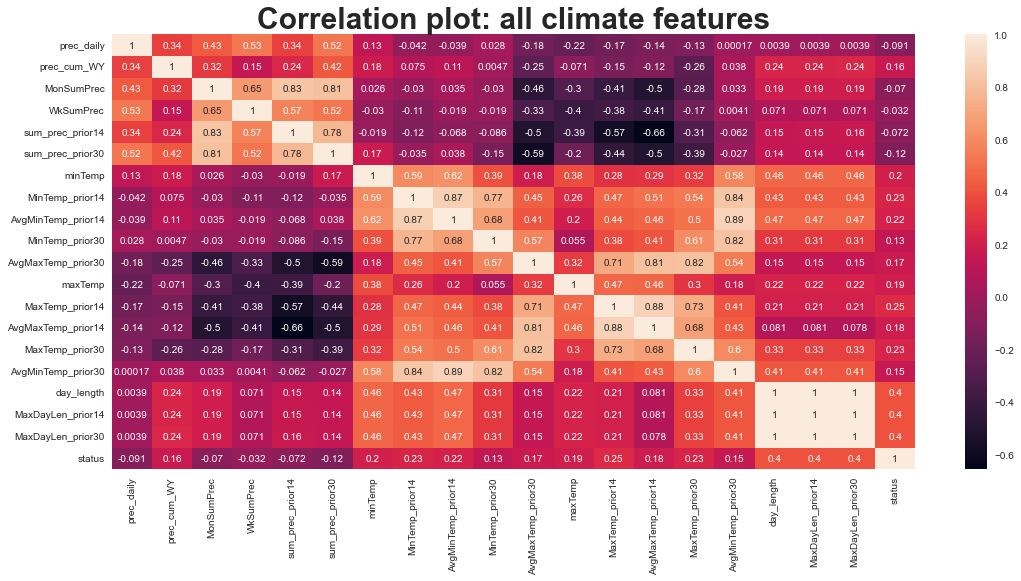

In [8]:
#Plot the correlation heat map for all features

plt.subplots(figsize=(18,8))
plt.title('Correlation plot: all climate features', fontsize = 30, weight = 'bold')
sns.heatmap(df_train_model.corr(), annot=True)
plt.show()

### 3c. boxplots of climate features
<br>prec_daily has a lot of outliers

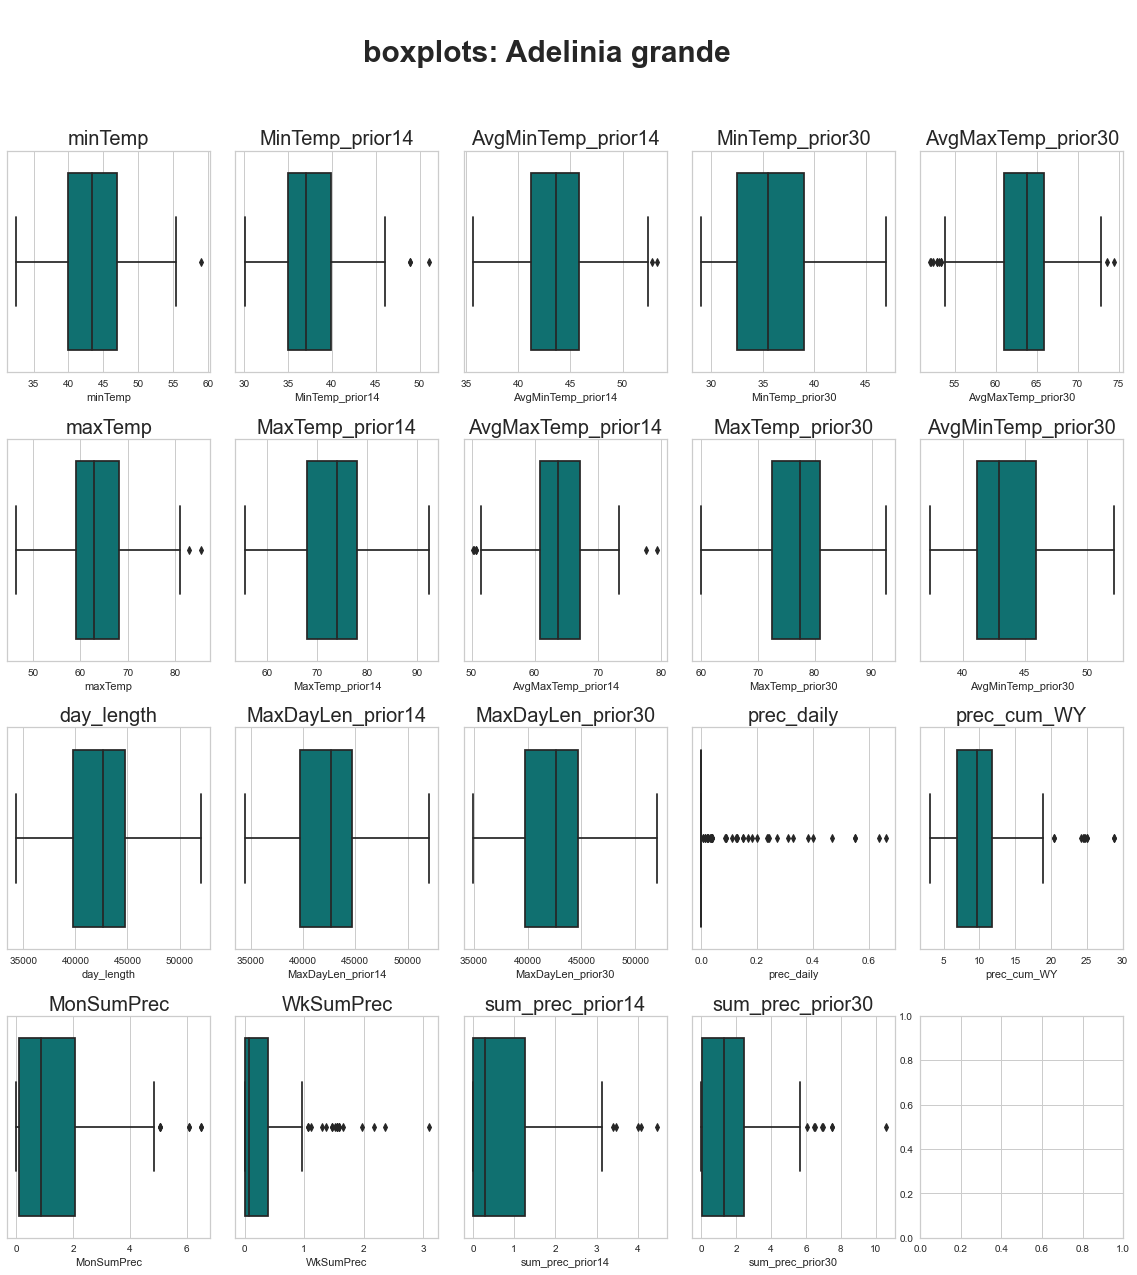

In [9]:
#Boxplots of climate variables
columns = ['minTemp', 'MinTemp_prior14', 'AvgMinTemp_prior14','MinTemp_prior30', 'AvgMaxTemp_prior30', 
           'maxTemp', 'MaxTemp_prior14', 'AvgMaxTemp_prior14','MaxTemp_prior30', 'AvgMinTemp_prior30',
           'day_length', 'MaxDayLen_prior14', 'MaxDayLen_prior30','prec_daily','prec_cum_WY', 
           'MonSumPrec', 'WkSumPrec', 'sum_prec_prior14','sum_prec_prior30'
          ]

ax0 = [0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4]
ax1 = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3]

tups = list(zip(ax1 ,ax0))

fig, axes = plt.subplots(4, 5, figsize=(20, 20))
fig.suptitle('\nboxplots: Adelinia grande', fontsize=30, weight='bold')
fig.subplots_adjust(hspace=0.3, wspace=0.125)

for col, ax in zip(columns, tups):
    sns.boxplot(x=df_train_model[col], ax=axes[ax], color = 'teal'), 
    axes[ax].set_title(str(col), fontsize=20)

[Link to top](#top) <a id='select'></a>
# 4. Feature and model selection with Pycaret

In [10]:
#look at df_train_model
print(df_train_model.shape)
df_train_model.head()

(189, 20)


,prec_daily,prec_cum_WY,MonSumPrec,WkSumPrec,sum_prec_prior14,sum_prec_prior30,minTemp,MinTemp_prior14,AvgMinTemp_prior14,MinTemp_prior30,AvgMaxTemp_prior30,maxTemp,MaxTemp_prior14,AvgMaxTemp_prior14,MaxTemp_prior30,AvgMinTemp_prior30,day_length,MaxDayLen_prior14,MaxDayLen_prior30,status
15,0.000000,8.724409,0.021654,0.000000,-8.881784e-16,-8.881784e-16,35.96,32.45,35.645000,32.45,64.085,72.95,72.95,64.059286,72.95,37.745,38049.0,38049.0,38049.0,0
26,0.000000,8.724409,0.021654,0.000000,-8.881784e-16,-8.881784e-16,43.43,32.45,37.130000,32.45,65.801,76.01,77.45,67.627143,77.45,37.943,38566.0,38566.0,38566.0,0
35,0.000000,8.724409,0.021654,0.021654,-8.881784e-16,-8.881784e-16,37.49,33.53,39.958571,32.45,66.623,71.51,77.45,70.282143,77.45,38.015,39509.0,39509.0,39509.0,1
42,0.005906,8.730315,0.021654,0.021654,5.905512e-03,5.905512e-03,34.52,34.52,40.280000,32.45,66.173,57.47,77.45,69.170000,77.45,37.733,39785.0,39785.0,39785.0,1
57,0.000000,8.771654,0.415354,0.025591,4.724409e-02,4.724409e-02,38.57,30.11,37.676429,30.11,66.326,57.47,75.47,62.670714,77.45,38.549,41487.0,41487.0,41487.0,1


### 4a. drop fixed-period features not evenly measured from current date: 'MonSumPrec', 'WkSumPrec'

In [11]:
#select desired features
df_train_model = df_ag[['prec_daily','prec_cum_WY','sum_prec_prior14','sum_prec_prior30', 
           'minTemp', 'MinTemp_prior14', 'AvgMinTemp_prior14','MinTemp_prior30', 'AvgMaxTemp_prior30',
           'maxTemp', 'MaxTemp_prior14', 'AvgMaxTemp_prior14','MaxTemp_prior30', 'AvgMinTemp_prior30', 
           'day_length', 'MaxDayLen_prior14', 'MaxDayLen_prior30',
           'status']]

print(df_train_model.shape)
df_train_model.head()

(189, 18)


,prec_daily,prec_cum_WY,sum_prec_prior14,sum_prec_prior30,minTemp,MinTemp_prior14,AvgMinTemp_prior14,MinTemp_prior30,AvgMaxTemp_prior30,maxTemp,MaxTemp_prior14,AvgMaxTemp_prior14,MaxTemp_prior30,AvgMinTemp_prior30,day_length,MaxDayLen_prior14,MaxDayLen_prior30,status
15,0.000000,8.724409,-8.881784e-16,-8.881784e-16,35.96,32.45,35.645000,32.45,64.085,72.95,72.95,64.059286,72.95,37.745,38049.0,38049.0,38049.0,0
26,0.000000,8.724409,-8.881784e-16,-8.881784e-16,43.43,32.45,37.130000,32.45,65.801,76.01,77.45,67.627143,77.45,37.943,38566.0,38566.0,38566.0,0
35,0.000000,8.724409,-8.881784e-16,-8.881784e-16,37.49,33.53,39.958571,32.45,66.623,71.51,77.45,70.282143,77.45,38.015,39509.0,39509.0,39509.0,1
42,0.005906,8.730315,5.905512e-03,5.905512e-03,34.52,34.52,40.280000,32.45,66.173,57.47,77.45,69.170000,77.45,37.733,39785.0,39785.0,39785.0,1
57,0.000000,8.771654,4.724409e-02,4.724409e-02,38.57,30.11,37.676429,30.11,66.326,57.47,75.47,62.670714,77.45,38.549,41487.0,41487.0,41487.0,1


### 4b.  split data into training (%80) and testing (20%) sets
<br> Code Source: 
<br>https://github.com/arnaldo9408/IpZDfXDexbdIJIWY/blob/main/Team%20Deposit%20Marketing.ipynb
<br>
<br>Methods:
<br> model was trained on data from 7 parks over 5 years
<br> 80 percent of the data was used to train the model, 20 percent to test it


In [12]:
# Get the dependent and independent feature(s)
X = df_train_model.drop('status', axis = 1).values
y = df_train_model['status'].values

# Divide into train (80%) and test data (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, shuffle = True)

### 4c. run Pycaret feature/model selection

In [13]:
# Start the feature selection

# Define RFE (recursive feature elimination)
rfe_dt = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=15)
rfe_rf = RFE(estimator=RandomForestClassifier(), n_features_to_select=15)
rfe_gb = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=15)

# fit RFE
rfe_dt.fit(X_train, y_train)
rfe_rf.fit(X_train, y_train)
rfe_gb.fit(X_train, y_train)

# Create a list with the features, status as index, then remove index
features = list(df_train_model.columns)
index = features.index('status')
features.pop(index)

# Create an empty list to see if the feature was selected
is_selected_dt = []
is_selected_rf = []
is_selected_gb = []

# Create an empty list with the rank
ranks_dt = []
ranks_rf = []
ranks_gb = []

# Summarize all features
for i in range(X.shape[1]):
    is_selected_value = rfe_dt.support_[i]
    is_selected_dt.append(is_selected_value)
    rank = rfe_dt.ranking_[i]
    ranks_dt.append(rank)
    
for i in range(X.shape[1]):
    is_selected_value = rfe_rf.support_[i]
    is_selected_rf.append(is_selected_value)
    rank = rfe_rf.ranking_[i]
    ranks_rf.append(rank)    
    
for i in range(X.shape[1]):
    is_selected_value = rfe_gb.support_[i]
    is_selected_gb.append(is_selected_value)
    rank = rfe_gb.ranking_[i]
    ranks_gb.append(rank)    

In [14]:
# Define a function that will sort the ranks of each feature and if the feature was selected
def df_converter(is_selected, ranks):
    feature_selection = pd.DataFrame()
    feature_selection['Feature'] = features
    feature_selection['is_selected'] = is_selected
    feature_selection['ranks'] = ranks
    sorted_ranks = feature_selection.sort_values(by = 'ranks', ascending = True).reset_index(drop = True)
    return sorted_ranks

# Function that converts the arrays created to data frame
def converter_df(train_independent, train_dependent):
    df = pd.DataFrame(train_independent)
    df['dependent'] = train_dependent
    return df

In [15]:
# Create the data frame for the train data
df = converter_df(train_independent = X_train, train_dependent = y_train)

In [16]:
# Setup the dataset
grid = setup(data = df, target = df.columns[-1]) #dependent variable is last column
#grid = setup(data = df, target = df.columns[-1], log_experiment = True) #dependent variable is last column

# Evaluate models and compare models
best = compare_models(fold = 10)
#log = get_logs()

# Report the best model
print(best)

,Description,Value
0,Session id,985
1,Target,dependent
2,Target type,Multiclass
3,Target mapping,"0: 0, 1: 1, 3: 2"
4,Original data shape,"(151, 18)"
5,Transformed data shape,"(151, 18)"
6,Transformed train set shape,"(105, 18)"
7,Transformed test set shape,"(46, 18)"
8,Numeric features,17
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8682,0.5905,0.8682,0.7719,0.8146,0.3313,0.3435,0.0400
gbc,Gradient Boosting Classifier,0.8682,0.5564,0.8682,0.7862,0.8213,0.3757,0.3956,0.0370
xgboost,Extreme Gradient Boosting,0.8682,0.5320,0.8682,0.7766,0.8177,0.3873,0.3998,0.0160
lightgbm,Light Gradient Boosting Machine,0.8682,0.4884,0.8682,0.7784,0.8181,0.3775,0.4020,0.0780
et,Extra Trees Classifier,0.8591,0.6230,0.8591,0.8080,0.8289,0.3920,0.4052,0.0330
catboost,CatBoost Classifier,0.8582,0.6007,0.8582,0.7697,0.8086,0.3104,0.3169,0.4130
dt,Decision Tree Classifier,0.8482,0.5189,0.8482,0.7797,0.8089,0.3463,0.3538,0.0080
knn,K Neighbors Classifier,0.8473,0.4518,0.8473,0.7310,0.7834,0.1603,0.1702,0.1510
dummy,Dummy Classifier,0.8291,0.3500,0.8291,0.6887,0.7520,0.0000,0.0000,0.0080
ada,Ada Boost Classifier,0.8200,0.4367,0.8200,0.7474,0.7760,0.1807,0.1952,0.0170


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=985, verbose=0, warm_start=False)


### model selection summary:
<br>19 features selected, all in, 
<br>ac = 88-89%, sometimes above 90, 
<br>best models: catboost, extra trees, random forest, knn, gradient boosting
<br>
<br>**BEST MODEL**
<br>17 features selected,  Drop: *prec_daily, *mon_sum_prec
<br>ac = 88-91% sometimes up to 95%, 
<br>best models: random forest, knn, extra trees, catboost, extreme gradient 
<br>
<br>15 features selected, Drop: prec_daily, mon_sum_prec, min_temp_prior30, MaxDayLen_prior14 
<br>ac = 88-89% up to 92%
<br>best models: knn, random forest, gradient boosting, extra trees, catboost
<br>
<br>10 features selected, Drop: prec_daily, mon_sum_prec, min_temp_prior30, sum_prec_prior14, 
<br>wk_sum_prec, min_temp, day_length, MaxDayLen_prior14, AvgMaxTemp_prior14
<br>ac = 88-90%
<br>best models: knn, random forest, extra trees, catboost, extreme gradient boosting
<br>
<br>8 features selected, max temp and daylength are most important, ac = 88-89, occasional 92
<br>random forest, knn, ridge, extra trees

In [17]:
# Feature Selection for Random Forest Classifier

df_converter(is_selected = is_selected_rf, ranks = ranks_rf)

,Feature,is_selected,ranks
0,AvgMaxTemp_prior30,True,1
1,day_length,True,1
2,AvgMinTemp_prior30,True,1
3,MaxTemp_prior30,True,1
4,MaxTemp_prior14,True,1
5,maxTemp,True,1
6,MaxDayLen_prior14,True,1
7,MaxDayLen_prior30,True,1
8,AvgMinTemp_prior14,True,1
9,MinTemp_prior14,True,1


In [18]:
# Feature Selection for Gradient Boosting Classifier

df_converter(is_selected = is_selected_gb, ranks = ranks_gb)

,Feature,is_selected,ranks
0,prec_daily,True,1
1,day_length,True,1
2,AvgMinTemp_prior30,True,1
3,MaxTemp_prior30,True,1
4,MaxTemp_prior14,True,1
5,maxTemp,True,1
6,MaxDayLen_prior14,True,1
7,AvgMaxTemp_prior30,True,1
8,AvgMinTemp_prior14,True,1
9,MinTemp_prior14,True,1


In [19]:
# Feature Selection for Decision Trees Classifier

df_converter(is_selected = is_selected_dt, ranks = ranks_dt)

,Feature,is_selected,ranks
0,MaxDayLen_prior30,True,1
1,prec_cum_WY,True,1
2,sum_prec_prior14,True,1
3,sum_prec_prior30,True,1
4,minTemp,True,1
5,MinTemp_prior14,True,1
6,AvgMinTemp_prior14,True,1
7,MinTemp_prior30,True,1
8,MaxDayLen_prior14,True,1
9,maxTemp,True,1


[Link to top](#top) <a id='train'></a>
# 5. Train the model: Adelinia grande, Pacific Hound's Tongue

In [20]:
#model with all features
#df_train_model = df_ag[['prec_daily','prec_cum_WY', 'MonSumPrec', 'WkSumPrec', 'sum_prec_prior14','sum_prec_prior30', 
#           'minTemp', 'MinTemp_prior14', 'AvgMinTemp_prior14','MinTemp_prior30', 'AvgMaxTemp_prior30',
#           'maxTemp', 'MaxTemp_prior14', 'AvgMaxTemp_prior14','MaxTemp_prior30', 'AvgMinTemp_prior30', 
#           'day_length', 'MaxDayLen_prior14', 'MaxDayLen_prior30',
#           'status']]
        
#model for 17 features, Drop: 'WkSumPrec', 'MonSumPrec'
df_train_model = df_ag[['prec_daily','prec_cum_WY','sum_prec_prior14','sum_prec_prior30', 
           'minTemp', 'MinTemp_prior14', 'AvgMinTemp_prior14','MinTemp_prior30', 'AvgMaxTemp_prior30',
           'maxTemp', 'MaxTemp_prior14', 'AvgMaxTemp_prior14','MaxTemp_prior30', 'AvgMinTemp_prior30', 
           'day_length', 'MaxDayLen_prior14', 'MaxDayLen_prior30',
           'status']]

#model for 16 features, Drop: 'prec_daily', 'WkSumPrec', 'MonSumPrec'
#df_train_model = df_ag[['prec_cum_WY','sum_prec_prior14','sum_prec_prior30', 
#           'minTemp', 'MinTemp_prior14', 'AvgMinTemp_prior14','MinTemp_prior30', 'AvgMaxTemp_prior30',
#           'maxTemp', 'MaxTemp_prior14', 'AvgMaxTemp_prior14','MaxTemp_prior30', 'AvgMinTemp_prior30', 
#           'day_length', 'MaxDayLen_prior14', 'MaxDayLen_prior30',
#           'status']]

#model for 15 features, Drop: 'prec_daily', 'MonSumPrec', 'MinTemp_prior30', 'MaxDayLen_prior14'
#df_train_model = df_ag[['prec_cum_WY', 'WkSumPrec', 'sum_prec_prior14','sum_prec_prior30', 
#           'minTemp', 'MinTemp_prior14', 'AvgMinTemp_prior14', 'AvgMaxTemp_prior30',
#           'maxTemp', 'MaxTemp_prior14', 'AvgMaxTemp_prior14','MaxTemp_prior30', 'AvgMinTemp_prior30', 
#           'day_length', 'MaxDayLen_prior30',
#           'status']]

#model for 10 features, Drop: prec_daily, mon_sum_prec, min_temp_prior30, sum_prec_prior14, 
#wk_sum_prec, min_temp, day_length, MaxDayLen_prior14, AvgMaxTemp_prior14
#df_train_model = df_ag[['prec_cum_WY', 'sum_prec_prior30', 
#           'MinTemp_prior14', 'AvgMinTemp_prior14', 'AvgMaxTemp_prior30',
#           'maxTemp', 'MaxTemp_prior14', 'MaxTemp_prior30', 'AvgMinTemp_prior30', 
#           'MaxDayLen_prior30',
#           'status']]

#30 day prior
#df_train_model = df_ag[['prec_cum_WY', 'WkSumPrec','sum_prec_prior30', 
#           'MinTemp_prior30', 'AvgMaxTemp_prior30',
#           'MaxTemp_prior30', 'AvgMinTemp_prior30', 
#           'MaxDayLen_prior30',
#           'status']]

print(df_train_model.shape)
df_train_model.head()

(189, 18)


,prec_daily,prec_cum_WY,sum_prec_prior14,sum_prec_prior30,minTemp,MinTemp_prior14,AvgMinTemp_prior14,MinTemp_prior30,AvgMaxTemp_prior30,maxTemp,MaxTemp_prior14,AvgMaxTemp_prior14,MaxTemp_prior30,AvgMinTemp_prior30,day_length,MaxDayLen_prior14,MaxDayLen_prior30,status
15,0.000000,8.724409,-8.881784e-16,-8.881784e-16,35.96,32.45,35.645000,32.45,64.085,72.95,72.95,64.059286,72.95,37.745,38049.0,38049.0,38049.0,0
26,0.000000,8.724409,-8.881784e-16,-8.881784e-16,43.43,32.45,37.130000,32.45,65.801,76.01,77.45,67.627143,77.45,37.943,38566.0,38566.0,38566.0,0
35,0.000000,8.724409,-8.881784e-16,-8.881784e-16,37.49,33.53,39.958571,32.45,66.623,71.51,77.45,70.282143,77.45,38.015,39509.0,39509.0,39509.0,1
42,0.005906,8.730315,5.905512e-03,5.905512e-03,34.52,34.52,40.280000,32.45,66.173,57.47,77.45,69.170000,77.45,37.733,39785.0,39785.0,39785.0,1
57,0.000000,8.771654,4.724409e-02,4.724409e-02,38.57,30.11,37.676429,30.11,66.326,57.47,75.47,62.670714,77.45,38.549,41487.0,41487.0,41487.0,1


In [21]:
#create lists to store model metrics
model_train_list = []
ac_train_list = []
precision_train_list = []
recall_train_list = []

In [22]:
#Create dummy features for object type features.
X = df_train_model.drop('status', axis=1)
X = pd.get_dummies(X)
y = df_train_model['status']

<a id='train_rf'></a>
### 5a. Random Forest

In [23]:
#define X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

#scale data
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

#implement the random forest classifier
rf = RandomForestClassifier(n_estimators=1000, random_state = 1,n_jobs=-1)
model_res = rf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
true_pos = np.diag(cm) 
precision = np.sum(true_pos / np.sum(cm, axis=0))
recall = np.sum(true_pos / np.sum(cm, axis=1))

model_train_list.append('Random Forest')
ac_train_list.append(ac)
precision_train_list.append(precision)
recall_train_list.append(recall)

print('Random Forest: Accuracy=%.3f' % (ac))
print('Random Forest: f1-score=%.3f' % (f1))
print('Precision = %.3f' % (precision))
print('Recall = %.3f' % (recall))
print('')
print('')
print("Adelinia grande: blooming confusion matrix ")
print(cm)


Random Forest: Accuracy=0.842
Random Forest: f1-score=0.849
Precision = 1.301
Recall = 1.576


Adelinia grande: blooming confusion matrix 
[[ 0  0  2]
 [ 1 30  2]
 [ 0  1  2]]


17


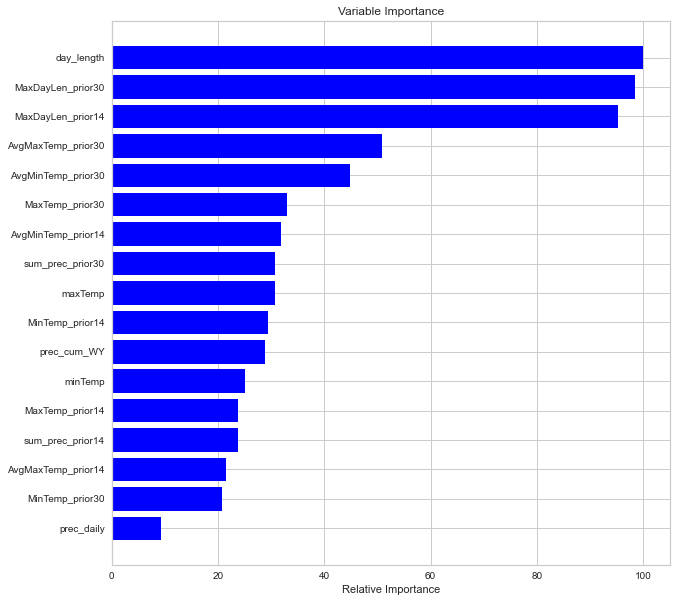

In [24]:
feature_importance = rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'blue')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [25]:
rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=-1, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)

<a id='train_knn'></a>
### 5b. K Nearest Neighbor

In [26]:
#define X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

#scale data
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
model_res = knn.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

#f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
true_pos = np.diag(cm) 
precision = np.sum(true_pos / np.sum(cm, axis=0))
recall = np.sum(true_pos / np.sum(cm, axis=1))

model_train_list.append('KNN')
ac_train_list.append(ac)
precision_train_list.append(precision)
recall_train_list.append(recall)

print('KNN: Accuracy=%.3f' % (ac))
print('Precision = %.3f' % (precision))
print('Recall = %.3f' % (recall))
print('')
print("Adelinia grande: blooming confusion matrix ")
print(cm)


KNN: Accuracy=0.816
Precision = 1.271
Recall = 1.242

Adelinia grande: blooming confusion matrix 
[[ 0  1  1]
 [ 2 30  1]
 [ 1  1  1]]


In [27]:
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

<a id='train_et'></a>
### 5c. Extra Trees

In [28]:
#define X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

#scale data
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

#Create Extra Trees Classifier
ext = ExtraTreesClassifier(n_estimators=100)

#Train the model using the training sets
model_res = ext.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
true_pos = np.diag(cm) 
precision = np.sum(true_pos / np.sum(cm, axis=0))
recall = np.sum(true_pos / np.sum(cm, axis=1))

model_train_list.append('Extra Trees')
ac_train_list.append(ac)
precision_train_list.append(precision)
recall_train_list.append(recall)

print('ext: Accuracy=%.3f' % (ac))
print('Precision = %.3f' % (precision))
print('Recall = %.3f' % (recall))
print('')
print("Adelinia grande: blooming confusion matrix ")
print(cm)

ext: Accuracy=0.868
Precision = 1.369
Recall = 1.606

Adelinia grande: blooming confusion matrix 
[[ 0  0  2]
 [ 1 31  1]
 [ 0  1  2]]


17


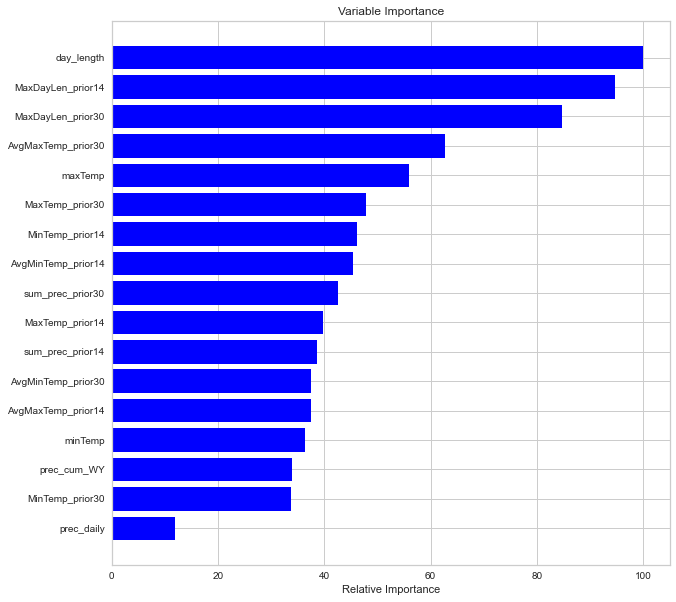

In [29]:
feature_importance = ext.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'blue')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [30]:
ext

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=None, oob_score=False,
                     random_state=None, verbose=0, warm_start=False)

<a id='train_gb'></a>
### 5d. Gradient Boosting

In [31]:
#define X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

#scale data
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

#Create Gradient Boosting Classifier
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100)

#Train the model using the training sets
model_res = gb.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
true_pos = np.diag(cm) 
precision = np.sum(true_pos / np.sum(cm, axis=0))
recall = np.sum(true_pos / np.sum(cm, axis=1))

model_train_list.append('Gradient Boosting')
ac_train_list.append(ac)
precision_train_list.append(precision)
recall_train_list.append(recall)

print('gb: Accuracy=%.3f' % (ac))
print('Precision = %.3f' % (precision))
print('Recall = %.3f' % (recall))
print('')
print("Adelinia grande: blooming confusion matrix ")
print(cm)

gb: Accuracy=0.789
Precision = 1.299
Recall = 1.515

Adelinia grande: blooming confusion matrix 
[[ 0  0  2]
 [ 3 28  2]
 [ 0  1  2]]


Feature: 0, Score: 7.51367
Feature: 1, Score: 47.01859
Feature: 2, Score: 24.86471
Feature: 3, Score: 36.00494
Feature: 4, Score: 17.03228
Feature: 5, Score: 30.32560
Feature: 6, Score: 11.82742
Feature: 7, Score: 2.55181
Feature: 8, Score: 23.54466
Feature: 9, Score: 38.87974
Feature: 10, Score: 15.71104
Feature: 11, Score: 12.44574
Feature: 12, Score: 15.20292
Feature: 13, Score: 43.12606
Feature: 14, Score: 90.81949
Feature: 15, Score: 100.00000
Feature: 16, Score: 63.45288
17


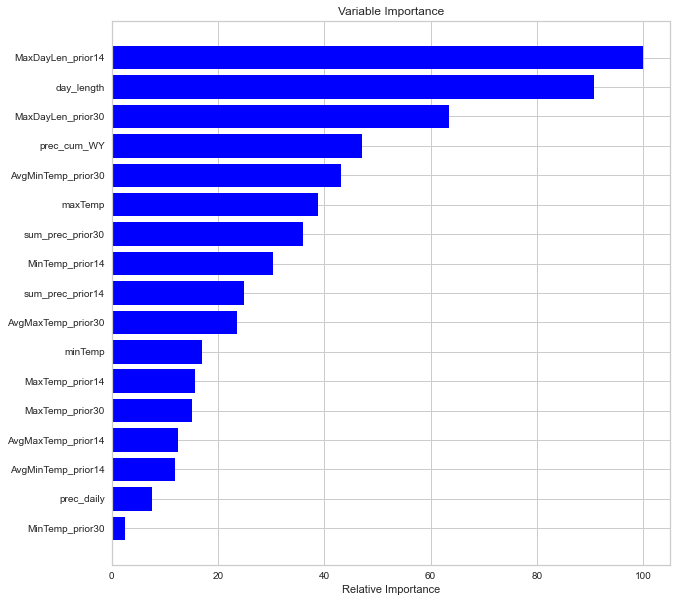

In [32]:
feature_importance = gb.feature_importances_
    
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

# summarize feature importance
for i,v in enumerate(feature_importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'blue')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [33]:
gb

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

<a id='train_model_comp'></a>
### 5e. table of training model comparisons

In [34]:
models_train_table = pd.DataFrame()
models_train_table.index = model_train_list
models_train_table['accuracy'] = ac_train_list
models_train_table['precision'] = precision_train_list
models_train_table['recall'] = recall_train_list

models_train_table.head(10)

,accuracy,precision,recall
Random Forest,0.842105,1.301075,1.575758
KNN,0.815789,1.270833,1.242424
Extra Trees,0.868421,1.368750,1.606061
Gradient Boosting,0.789474,1.298851,1.515152


[Link to top](#top) <a id='test'></a>
# 6. Test Model: Import unseen data
<br>New data is used from one park, Mt. Diablo, over 5 years

### 6a. import unseen data

In [35]:
# import Mt. Diablo, Adelinia grande, labeled test data from GitHub:Floydworks
url = ('https://raw.githubusercontent.com/Floydworks/WildflowerFinder_Phenology_Tool/main/cleaned_data_files/df_ag_test_mtdiablo_labeled.csv')
download = requests.get(url).content

# Read the downloaded content and turn it into a pandas dataframe
df_ag_test_mtdiablo_labeled = pd.read_csv(io.StringIO(download.decode('utf-8')))

# assign new name for manipulation
df_test_model = df_ag_test_mtdiablo_labeled
print('df_ag_test_mtdiablo_labeled: ',df_test_model.shape)

df_ag_test_mtdiablo_labeled:  (216, 41)


### 6b. select and filter test data

In [36]:
#drop observations with status = 5
df = df_test_model[df_test_model.status != 5]
df['status'] = np.where(df['status'] == 2, 0, df['status'])

print(df['status'].unique())

print('df shape: ',df.shape)
df.head()


[0. 1. 3.]
df shape:  (216, 41)


,Unnamed: 0,id,park,plain_dates,Year,Month,Day,WY,wy_month,WY_weeknum,...,MaxDayLen_prior14,sum_prec_prior30,MaxTemp_prior30,MinTemp_prior30,AvgMaxTemp_prior30,AvgMinTemp_prior30,MaxDayLen_prior30,url,image_url,status
0,18920,105112877,MtDiablo,20220116,2022,1,16,2022,4,15,...,35451.0,4.027559e+00,64.94,28.94,50.942,39.782,35451.0,https://www.inaturalist.org/observations/10511...,https://inaturalist-open-data.s3.amazonaws.com...,0.0
1,18942,105457143,MtDiablo,20220122,2022,1,22,2022,4,15,...,36006.0,1.677165e+00,64.94,28.94,52.772,41.648,36006.0,https://www.inaturalist.org/observations/10545...,https://inaturalist-open-data.s3.amazonaws.com...,0.0
2,18964,105883395,MtDiablo,20220130,2022,1,30,2022,4,16,...,36870.0,9.842520e-02,64.94,33.08,57.206,44.834,36870.0,https://www.inaturalist.org/observations/10588...,https://inaturalist-open-data.s3.amazonaws.com...,1.0
3,18984,107786294,MtDiablo,20220130,2022,1,30,2022,4,16,...,36870.0,9.842520e-02,64.94,33.08,57.206,44.834,36870.0,https://www.inaturalist.org/observations/10778...,https://inaturalist-open-data.s3.amazonaws.com...,1.0
4,19000,106265580,MtDiablo,20220206,2022,2,6,2022,5,17,...,37719.0,-8.881784e-16,64.94,39.02,58.508,45.524,37719.0,https://www.inaturalist.org/observations/10626...,https://static.inaturalist.org/photos/17848435...,1.0


In [37]:
print(df['park'].unique())
print(df['genus_species'].unique())

['MtDiablo']
['Adelinia grande']


**Look at counts by status and species**

In [38]:
#get number of obesrvations in each status class for each species and convert to a dataframe
df_counts = df.groupby(['genus_species', 'status'])['id'].count().to_frame()
#create total_obs column fill with nan placeholders
df_counts['total_obs'] = 'nan'
#reset the index and move genus_species to a column
df_counts=df_counts.reset_index()
#get list of species to iterate through
spp = df_counts['genus_species'].unique()
#go through species and add total observations of that species to the total_obs column
for sp in spp:
    sum_obs = df_counts.loc[df_counts['genus_species'] == sp, 'id'].sum()
    df_counts['total_obs'] = np.where(df_counts['genus_species'] == sp, sum_obs, df_counts['total_obs'])
 #calculate the percentage of observations for each status class  and species  
df_counts['percent_obs'] = df_counts['id']/df_counts['total_obs']

df_counts

,genus_species,status,id,total_obs,percent_obs
0,Adelinia grande,0.0,25,216,0.115741
1,Adelinia grande,1.0,170,216,0.787037
2,Adelinia grande,3.0,21,216,0.097222


In [39]:
#select species of interest
df_ag_test = df[df['genus_species']=='Adelinia grande']

#model for 16 features, Drop: 'prec_daily', 'WkSumPrec', 'MonSumPrec'
df_ag_test = df_ag_test[['prec_daily', 'prec_cum_WY', 'sum_prec_prior14','sum_prec_prior30', 
           'minTemp', 'MinTemp_prior14', 'AvgMinTemp_prior14','MinTemp_prior30', 'AvgMaxTemp_prior30',
           'maxTemp', 'MaxTemp_prior14', 'AvgMaxTemp_prior14','MaxTemp_prior30', 'AvgMinTemp_prior30', 
           'day_length', 'MaxDayLen_prior14', 'MaxDayLen_prior30',
           'status']]

print(df_ag_test.shape)
df_ag_test.head()

(216, 18)


,prec_daily,prec_cum_WY,sum_prec_prior14,sum_prec_prior30,minTemp,MinTemp_prior14,AvgMinTemp_prior14,MinTemp_prior30,AvgMaxTemp_prior30,maxTemp,MaxTemp_prior14,AvgMaxTemp_prior14,MaxTemp_prior30,AvgMinTemp_prior30,day_length,MaxDayLen_prior14,MaxDayLen_prior30,status
0,0.0,18.744094,9.842520e-02,4.027559e+00,51.08,39.02,44.908571,28.94,50.942,60.98,64.94,56.852857,64.94,39.782,35451.0,35451.0,35451.0,0.0
1,0.0,18.744094,-8.881784e-16,1.677165e+00,46.04,39.92,47.698571,28.94,52.772,55.94,64.94,59.925714,64.94,41.648,36006.0,36006.0,36006.0,0.0
2,0.0,18.744094,-8.881784e-16,9.842520e-02,46.04,44.06,46.297143,33.08,57.206,57.92,60.98,59.231429,64.94,44.834,36870.0,36870.0,36870.0,1.0
3,0.0,18.744094,-8.881784e-16,9.842520e-02,46.04,44.06,46.297143,33.08,57.206,57.92,60.98,59.231429,64.94,44.834,36870.0,36870.0,36870.0,1.0
4,0.0,18.744094,-8.881784e-16,-8.881784e-16,46.94,39.92,43.777143,39.02,58.508,59.00,60.98,57.945714,64.94,45.524,37719.0,37719.0,37719.0,1.0


[Link to top](#top) <a id='test_visualize'></a>
# 7. Visualize climate features 

### 7a. correlation plot of all climate features in Adelinia grande dataframe

<AxesSubplot:title={'center':'Correlation of climate variables'}>

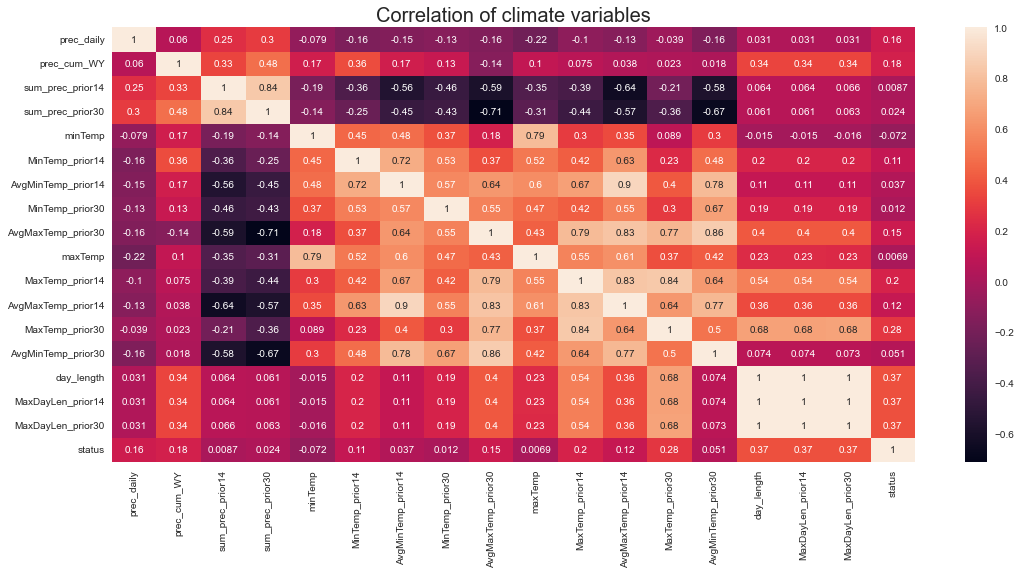

In [40]:
#Plot the correlation heat map for the features

plt.subplots(figsize=(18,8))
plt.title('Correlation of climate variables', fontsize = 20)
sns.heatmap(df_ag_test.corr(), annot=True)

### 7b. boxplots of climate features

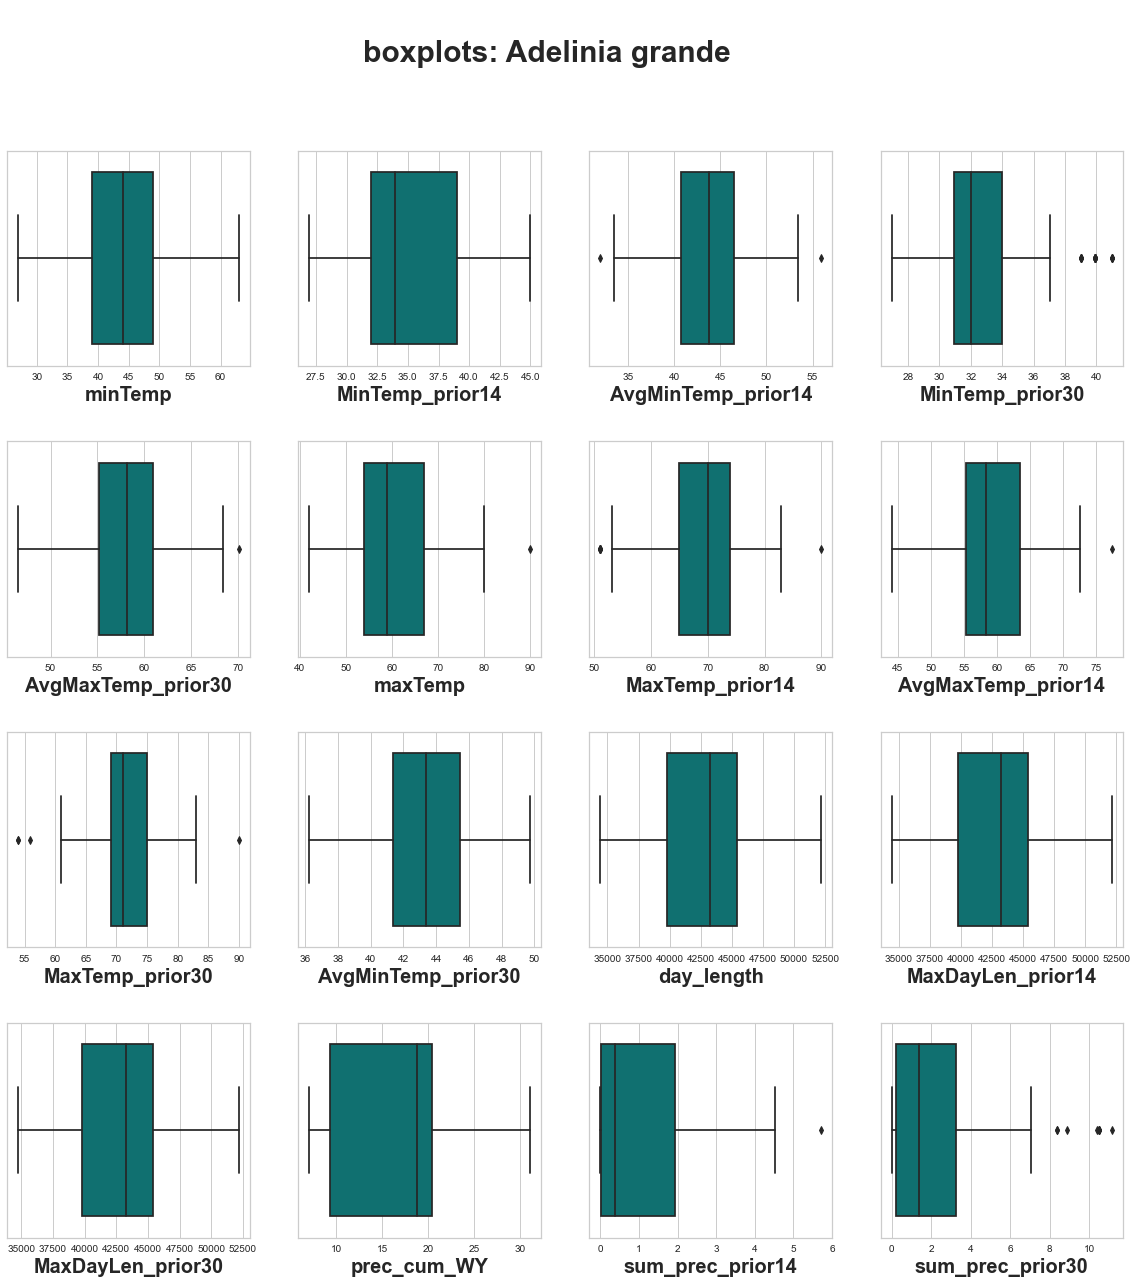

In [41]:
#Boxplots of climate variables
columns = ['minTemp', 'MinTemp_prior14', 'AvgMinTemp_prior14','MinTemp_prior30', 'AvgMaxTemp_prior30', 
           'maxTemp', 'MaxTemp_prior14', 'AvgMaxTemp_prior14','MaxTemp_prior30', 'AvgMinTemp_prior30',
           'day_length', 'MaxDayLen_prior14', 'MaxDayLen_prior30','prec_cum_WY', 
           'sum_prec_prior14','sum_prec_prior30'
          ]

ax0 = [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]
ax1 = [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]

tups = list(zip(ax1 ,ax0))

fig, axes = plt.subplots(4, 4, figsize=(20, 20))
plt.subplots_adjust(hspace = 0.35)
fig.suptitle('\nboxplots: Adelinia grande', fontsize=30, weight='bold')

for col, ax in zip(columns, tups):
    sns.boxplot(x=df_ag_test[col], ax=axes[ax], color = 'teal'), 
    #axes[ax].set_title(str(col), fontsize=20, weight='bold')
    axes[ax].set_xlabel(str(col), fontsize = 20, weight='bold')

[Link to top](#top)<a id='test_model'></a>
# 8. Model test data 

In [42]:
model_list = []
ac_list = []
precision_list = []
recall_list = []

In [43]:
df_ag_test.shape

(216, 18)

### 8a. test: Random Forest <a id='test_rf'></a>

In [44]:
#define X and y
#Create dummy features for object type features.
X_md = df_ag_test.drop('status', axis=1)
X_md = pd.get_dummies(X_md)
y_md = df_ag_test['status']



In [45]:
#define X and y
#Create dummy features for object type features.
#X_md = df_ag_test.drop('status', axis=1)
#X_md = pd.get_dummies(X)
#y_md = df_ag_test['status']


#scale data
# build scaler based on training data and apply it to test data to then also scale the test data
#scaler = preprocessing.StandardScaler().fit(X_train)
#X_train_scaled=scaler.transform(X_train)

#TEST DATA
X_md_scaled=scaler.transform(X_md)

#implement the random forest classifier
rf = RandomForestClassifier(n_estimators=1000, random_state = 1,n_jobs=-1)
model_res = rf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_md_scaled)
y_pred_prob = model_res.predict_proba(X_md_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_md, y_pred)

f1 = f1_score(y_md, y_pred, average='weighted')
cm = confusion_matrix(y_md, y_pred)
true_pos = np.diag(cm) 
precision = np.sum(true_pos / np.sum(cm, axis=0))
recall = np.sum(true_pos / np.sum(cm, axis=1))

model_list.append('Random Forest')
ac_list.append(ac)
precision_list.append(precision)
recall_list.append(recall)

print('Random Forest: Accuracy=%.3f' % (ac))
print('Random Forest: f1-score=%.3f' % (f1))
print('Precision = %.3f' % (precision))
print('Recall = %.3f' % (recall))
print('')
print('')
print("Adelinia grande: blooming confusion matrix ")
print(cm)

Random Forest: Accuracy=0.736
Random Forest: f1-score=0.707
Precision = 1.175
Recall = 1.208


Adelinia grande: blooming confusion matrix 
[[  8  15   2]
 [ 13 151   6]
 [  1  20   0]]


17


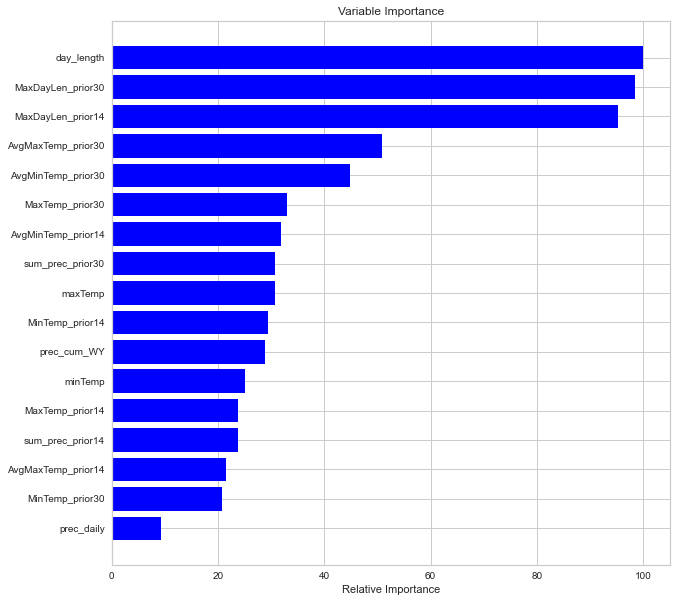

In [46]:
feature_importance = rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'blue')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### 8b. test: K Nearest Neighbor <a id='test_knn'></a>

In [47]:
#define X and y
#Create dummy features for object type features.
X_md = df_ag_test.drop('status', axis=1)
X_md = pd.get_dummies(X_md)
y_md = df_ag_test['status']

#scale data
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)

X_md_scaled=scaler.transform(X_md)

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=9)

#Train the model using the training sets
model_res = knn.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_md_scaled)
y_pred_prob = model_res.predict_proba(X_md_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_md, y_pred)

#f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_md, y_pred)
true_pos = np.diag(cm) 
precision = np.sum(true_pos / np.sum(cm, axis=0))
recall = np.sum(true_pos / np.sum(cm, axis=1))

model_list.append('KNN')
ac_list.append(ac)
precision_list.append(precision)
recall_list.append(recall)

print('KNN: Accuracy=%.3f' % (ac))
print('Precision = %.3f' % (precision))
print('Recall = %.3f' % (recall))
print('')
print("Adelinia grande: blooming confusion matrix ")
print(cm)

KNN: Accuracy=0.773
Precision = 1.260
Recall = 1.255

Adelinia grande: blooming confusion matrix 
[[  8  15   2]
 [ 10 159   1]
 [  0  21   0]]


In [48]:
true_pos = np.diag(cm) 
precision = np.sum(true_pos / np.sum(cm, axis=0))
recall = np.sum(true_pos / np.sum(cm, axis=1))

print(true_pos)
print(precision)
print(recall)

[  8 159   0]
1.2598290598290598
1.255294117647059


### 8c. test: Extra Trees <a id='test_et'></a>

In [49]:
#define X and y
#Create dummy features for object type features.
X_md = df_ag_test.drop('status', axis=1)
X_md = pd.get_dummies(X_md)
y_md = df_ag_test['status']

#scale data
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)

X_md_scaled=scaler.transform(X_md)

#Create extra trees Classifier
ext = ExtraTreesClassifier(n_estimators=100)

#Train the model using the training sets
model_res = ext.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_md_scaled)
y_pred_prob = model_res.predict_proba(X_md_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_md, y_pred)

#f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_md, y_pred)
true_pos = np.diag(cm) 
precision = np.sum(true_pos / np.sum(cm, axis=0))
recall = np.sum(true_pos / np.sum(cm, axis=1))

model_list.append('Extra Trees')
ac_list.append(ac)
precision_list.append(precision)
recall_list.append(recall)

print('ext: Accuracy=%.3f' % (ac))
print('Precision = %.3f' % (precision))
print('Recall = %.3f' % (recall))
print('')
print("Adelinia grande: blooming confusion matrix ")
print(cm)

ext: Accuracy=0.745
Precision = 1.129
Recall = 1.186

Adelinia grande: blooming confusion matrix 
[[  7  16   2]
 [ 14 154   2]
 [  1  20   0]]


17


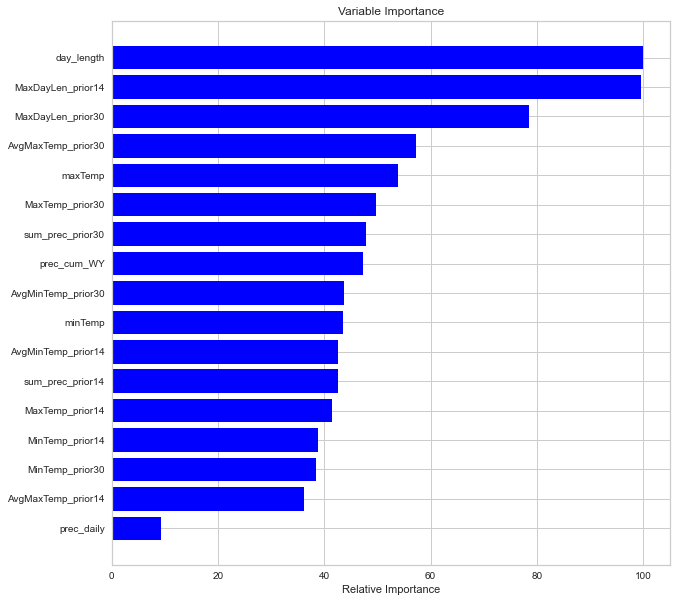

In [50]:
feature_importance = ext.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'blue')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### 8d. test: Gradient Boosting <a id='test_gb'></a>

In [51]:
#define X and y
#Create dummy features for object type features.
X_md = df_ag_test.drop('status', axis=1)
X_md = pd.get_dummies(X_md)
y_md = df_ag_test['status']

#scale data
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)

X_md_scaled=scaler.transform(X_md)

#Create extra trees Classifier
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100)

#Train the model using the training sets
model_res = gb.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_md_scaled)
y_pred_prob = model_res.predict_proba(X_md_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_md, y_pred)

#f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_md, y_pred)
true_pos = np.diag(cm) 
precision = np.sum(true_pos / np.sum(cm, axis=0))
recall = np.sum(true_pos / np.sum(cm, axis=1))

model_list.append('Gradient Boosting')
ac_list.append(ac)
precision_list.append(precision)
recall_list.append(recall)

print('gb: Accuracy=%.3f' % (ac))
print('Precision = %.3f' % (precision))
print('Recall = %.3f' % (recall))
print('')
print("Adelinia grande: blooming confusion matrix ")
print(cm)

gb: Accuracy=0.722
Precision = 1.194
Recall = 1.191

Adelinia grande: blooming confusion matrix 
[[  8  15   2]
 [ 11 148  11]
 [  2  19   0]]


17


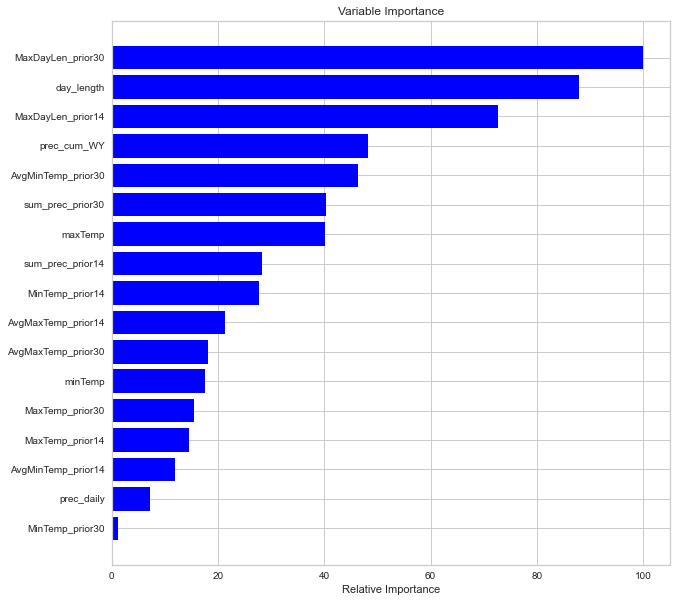

In [52]:
feature_importance = gb.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'blue')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### 8e. model comparisons<a id='test_model_comp'></a>

In [53]:
models_table = pd.DataFrame()
models_table.index = model_list
models_table['accuracy'] = ac_list
models_table['precision'] = precision_list
models_table['recall'] = recall_list

models_table.head(10)

,accuracy,precision,recall
Random Forest,0.736111,1.175464,1.208235
KNN,0.773148,1.259829,1.255294
Extra Trees,0.745370,1.128708,1.185882
Gradient Boosting,0.722222,1.194139,1.190588


[Link to top](#top)<a id='summary'></a>
# 9. summary